In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pennylane as qml

# Heat PDE for 2D with given BC and initial condition to predict at different time steps


The 2D heat equation is given by $$\frac{\partial u}{\partial t} = \alpha(\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})$$

In [14]:
num_points = 1000 # Number of randomly sampled points for IC and BC
alpha = 15 # thermal diffusivity

t_min, t_max, x_min, x_max, y_min, y_max = 0, 1, 0, 1, 0, 1
x_range, y_range, t_range = np.random.rand(num_points), np.random.rand(num_points), np.random.rand(num_points)
zeros = np.zeros(num_points)
ones = np.ones(num_points)
# [x, y, t, T]
bc1 = np.vstack([x_range, ones, t_range, ones*100]).T # Boundary top: u(x, y=1, t) = 100
bc2 = np.vstack([ones, y_range, t_range, zeros]).T # Boundary right: u(x=1, y, t) = 0
bc3 = np.vstack([x_range, zeros, t_range, zeros]).T # Boundary bottom: u(x, y=0, t) = 0
bc4 = np.vstack([zeros, y_range, t_range, zeros]).T # Boundary left: u(x=0, y0, t) = 0
ic = np.vstack([x_range, y_range, zeros, zeros]).T # IC u(x, y, t=0) = 0

initial_boundary_conditions = np.vstack([bc1, bc2, bc3, bc4, ic])

x_initial_bc = initial_boundary_conditions[:, 0]
y_initial_bc = initial_boundary_conditions[:, 1]
t_initial_bc = initial_boundary_conditions[:, 2]
u_initial_bc = initial_boundary_conditions[:, 3]

In [21]:
# Two arrays of shape (100,)
array1 = np.ones(100)
array2 = np.zeros(100)

# Using vstack
result = np.vstack((array1, array2)) 

print(x_range.shape)  # Output: (2, 100)

(1000,)


In [59]:
def loss_pde(x, y, t, net):
    # Convert inputs to tensors
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    # print(x.shape)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)
        
        inputs = tf.stack([x, y, t], axis=1)
        u = net(inputs)
        
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_y = tape.gradient(u, y)
        u_yy = tape.gradient(u_y, y)

    loss_pde = tf.reduce_mean((u_t - alpha * (u_xx + u_yy)) ** 2)
    
    del tape  # Explicitly delete the tape to release resources
    # print(loss_pde.dtype)
    return loss_pde
def ic_bc_loss(x, y, t, net, u_initial_bc):
    
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    inputs = tf.stack([x, y, t], axis=1)
    u_initial_bc = tf.constant(u_initial_bc, dtype=tf.float32)

    u_predicted_initial = net(inputs)
    mse_loss = tf.keras.losses.MeanSquaredError()
    loss_ic_bc = mse_loss(u_predicted_initial, u_initial_bc)
    # print(u_initial_bc.dtype)

    return loss_ic_bc

In [61]:
## Neural Net

NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 2, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                128       
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 2)                 66        
                                                                 
 dense_28 (Dense)            (None, 1)                 3         
                                                                 
Total params: 2309 (9.02 KB)
Trainable params: 2309 (9.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1781.2716
1699.329
1638.9315
1593.2966
1558.967
1534.8989
1520.7229
1509.9718
1448.4993
1354.071


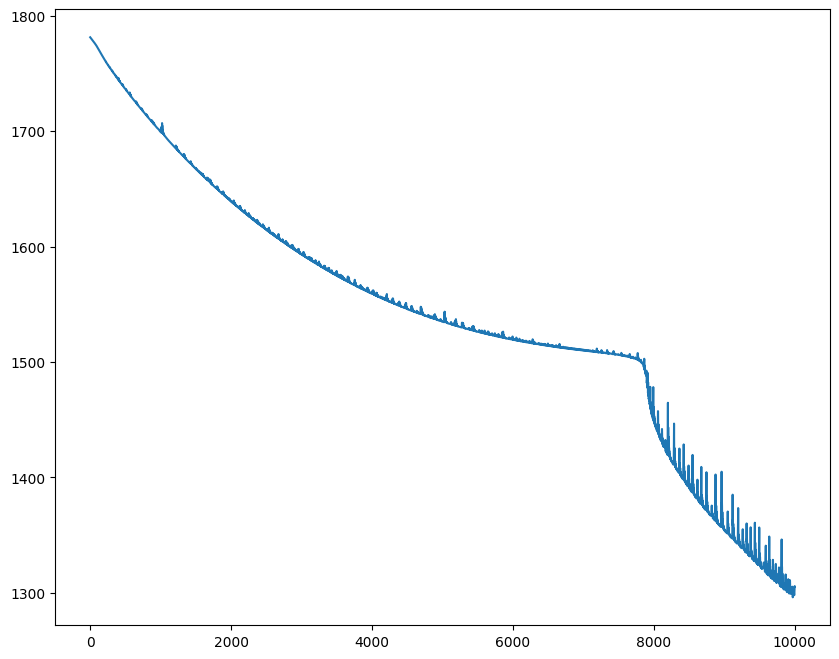

In [63]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []

# the training loop for the classical case 
for itr in range(10000):
    with tf.GradientTape() as tape:
        train_loss = loss_pde(x_initial_bc, y_initial_bc, t_initial_bc, NN) + ic_bc_loss(x_initial_bc, y_initial_bc, t_initial_bc, NN, u_initial_bc)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize = (10,8))
plt.plot(train_loss_record)
plt.show()

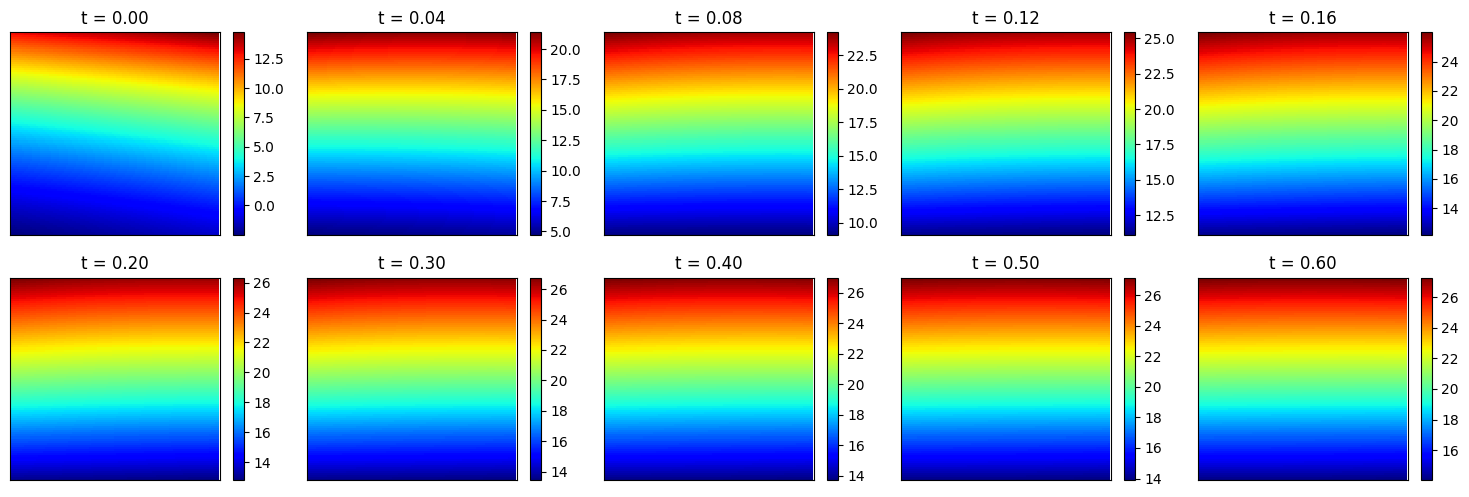

In [69]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NN(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()